Similarity and diversity
===

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import gzip
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

Read in our datasets
====

Get the set of compounds that have been test in man.
This dataset is available from ZINC: http://zinc.docking.org/subsets/zim

In [2]:
zims = [x for x in Chem.ForwardSDMolSupplier(gzip.open('data/zim.sdf.gz')) if x is not None]

Now get 10K natural products from ZINC:
This dataset is available from ZINC: http://zinc.docking.org/subsets/znp

In [3]:
znps = []
for x in Chem.ForwardSDMolSupplier(gzip.open('data/znp.sdf.gz')):
    if x is None: continue
    znps.append(x)
    if len(znps)==10000: break

Generate 2D coordinates (in ZINC they are 3D)

In [4]:
for m in zims: AllChem.Compute2DCoords(m)
for m in znps: AllChem.Compute2DCoords(m)
    

Generate Morgan fingerprints

In [5]:
zims_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in zims]
znps_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in znps]
          

Basic fingerprint operations
=====

Similarity:

In [6]:
DataStructs.TanimotoSimilarity(zims_fps[0],znps_fps[0])

0.125

A bunch of similarities (much faster than doing it one-by-one):

In [7]:
sims = DataStructs.BulkTanimotoSimilarity(zims_fps[0],znps_fps)

Plot those using pylab:

(array([  11,   66,  126,  414, 1029, 2182, 2222, 1536, 1129,  690,  347,
        168,   45,   11,    6,    7,    8,    2,    0,    1]),
 array([ 0.    ,  0.0175,  0.035 ,  0.0525,  0.07  ,  0.0875,  0.105 ,
        0.1225,  0.14  ,  0.1575,  0.175 ,  0.1925,  0.21  ,  0.2275,
        0.245 ,  0.2625,  0.28  ,  0.2975,  0.315 ,  0.3325,  0.35  ]),
 <a list of 20 Patch objects>)

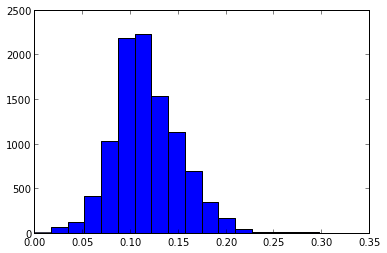

In [8]:
hist(sims,20)

Look at the molecules:

In [9]:
nbrs = sorted(zip(sims,znps),reverse=True)

In [10]:
nbrs[0],nbrs[-1]

((0.34999999999999998, <rdkit.Chem.rdchem.Mol at 0x10ef58280>),
 (0.0, <rdkit.Chem.rdchem.Mol at 0x10c754750>))

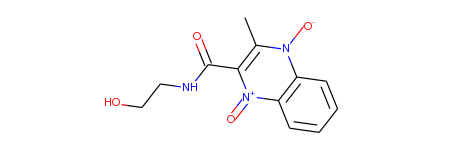

In [11]:
zims[0]

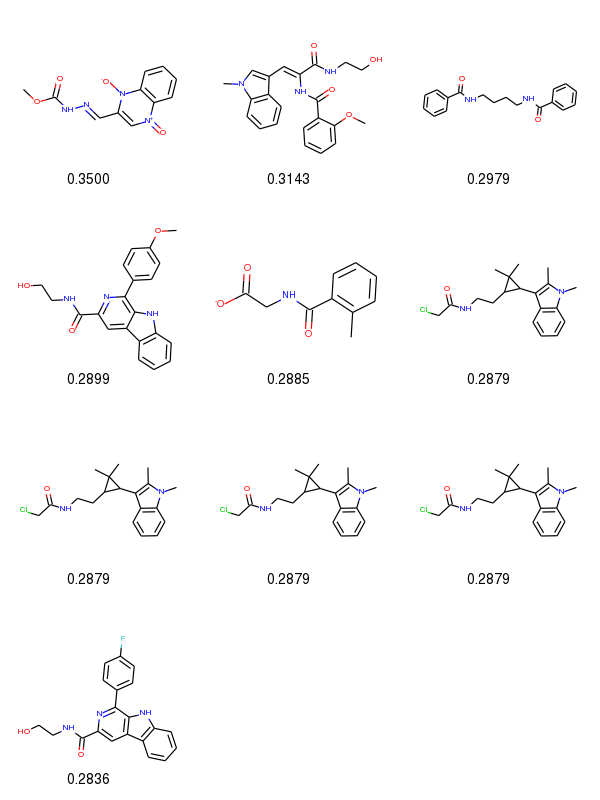

In [12]:
Draw.MolsToGridImage([x[1] for x in nbrs[:10]],legends=['%.4f'%x[0] for x in nbrs])

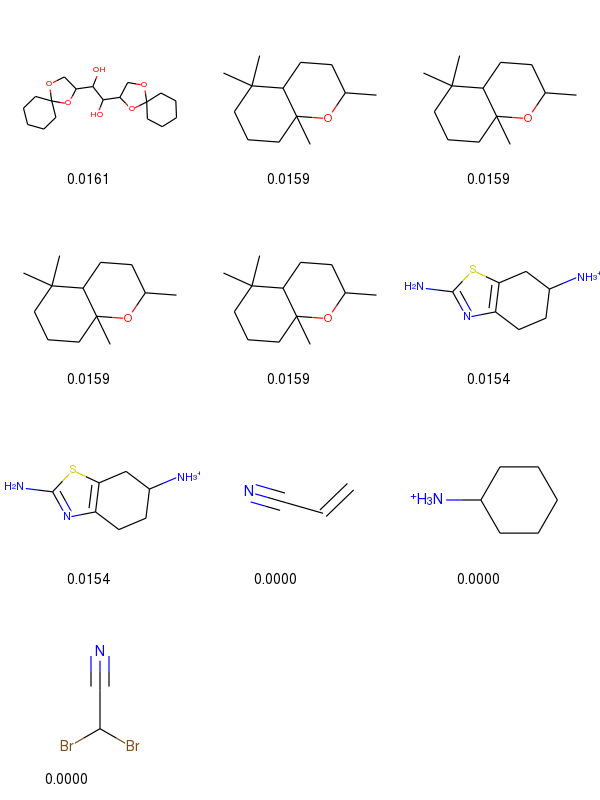

In [13]:
Draw.MolsToGridImage([x[1] for x in nbrs[-10:]],legends=['%.4f'%x[0] for x in nbrs[-10:]])

Diversity Picking
=======

Clustering vs MaxMin

Clustering: generating N clusters and pick their centroids

MaxMin (Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598-604): At each iteration pick the point that has the maximum minimum distance to currently picked points. 

![comparison figure](files/images/Cluster_Vs_MaxMin.png)

In [14]:
from rdkit.SimDivFilters import rdSimDivPickers

Pick some diverse compounds that have been tested in man.

Start by building the lower-triangle of the distance matrix:

In [15]:
dm=[]
for i,fp in enumerate(zims_fps[:1000]):     # only 1000 in the demo (in the interest of time)
    dm.extend(DataStructs.BulkTanimotoSimilarity(fp,zims_fps[1+1:1000],returnDistance=True))
dm = array(dm)

Now pick 50 diverse structures:

MaxMin algorithm
-----

Ashton, M. et al. Identification of Diverse Database Subsets using Property-Based and Fragment-Based Molecular Descriptions. QSAR & Combinatorial Science 21, 598–604 (2002).

In [16]:
picker = rdSimDivPickers.MaxMinPicker()

In [17]:
ids = picker.Pick(dm,1000,50)

In [18]:
list(ids[:10])

[374, 128, 633, 550, 126, 84, 538, 740, 876, 352]

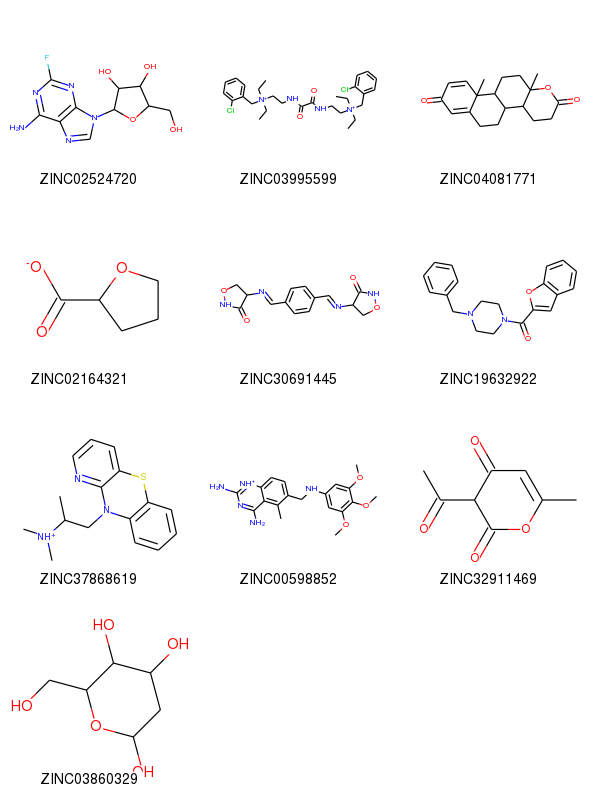

In [19]:
Draw.MolsToGridImage([zims[x] for x in ids[:10]],legends=[zims[x].GetProp('_Name') for x in ids])

We can also seed the pick, i.e. pick entries that are diverse w.r.t. a starting set.
Here will will do that relative to the first 5 zim structures:

In [20]:
ids = picker.Pick(dm,1000,50,firstPicks=[0,1,2,3,4])

In [21]:
list(ids[:10])

[0, 1, 2, 3, 4, 633, 348, 524, 550, 208]

Clustering
---

In [22]:
picker = rdSimDivPickers.HierarchicalClusterPicker(rdSimDivPickers.ClusterMethod.WARD)

In [23]:
ids = picker.Pick(dm,1000,50)

In [24]:
list(ids[:10])

[854, 276, 783, 810, 89, 911, 436, 63, 983, 912]

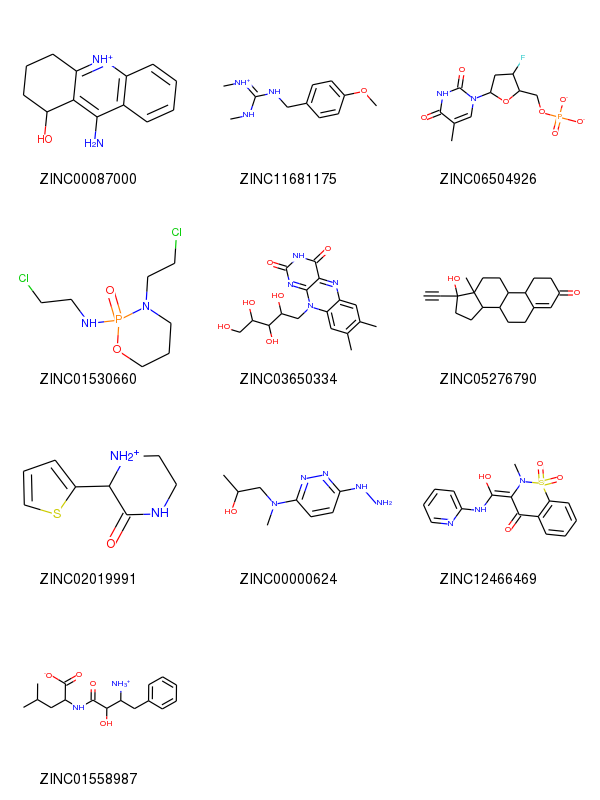

In [25]:
Draw.MolsToGridImage([zims[x] for x in ids[:10]],legends=[zims[x].GetProp('_Name') for x in ids])

Similarity Picking
====

Picking a set of neighbors

Top N Picker versus Spread Picker
----

Top N:  The top N most similar compounds to any active are selected.  
Spread:  The compound most similar to each active in the training set is chosen.  This process is repeated until the total desired number of compounds has been selected.


![illustration](files/images/similarity_pickers.jpg)

In [26]:
from rdkit.SimDivFilters.SimilarityPickers import TopNOverallPicker,SpreadPicker

In [27]:
for i,fp in enumerate(zims_fps): fp._idx=i
probeFps=zims_fps[:5]
dataset=zims_fps[5:]

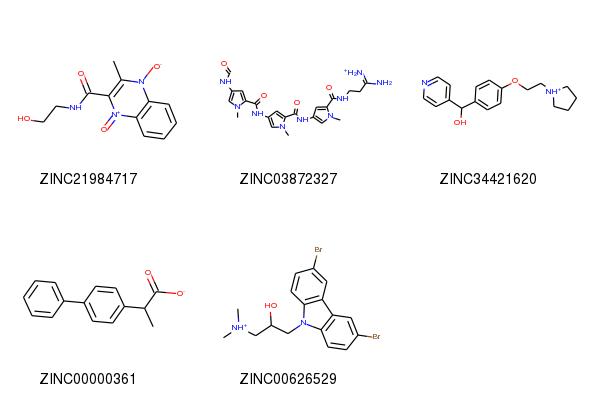

In [28]:
Draw.MolsToGridImage([x for x in zims[:5]],legends=[x.GetProp('_Name') for x in zims])

In [29]:
tpicker = TopNOverallPicker(numToPick=10,probeFps=probeFps,dataSet=dataset)

In [30]:
[(x[1],x[0]._idx) for x in tpicker]

[(1.0, 8841),
 (1.0, 7),
 (0.72093023255813948, 3517),
 (0.61764705882352944, 9584),
 (0.61764705882352944, 7603),
 (0.61111111111111116, 8460),
 (0.61111111111111116, 8308),
 (0.60606060606060608, 6774),
 (0.60606060606060608, 65),
 (0.56451612903225812, 2104)]

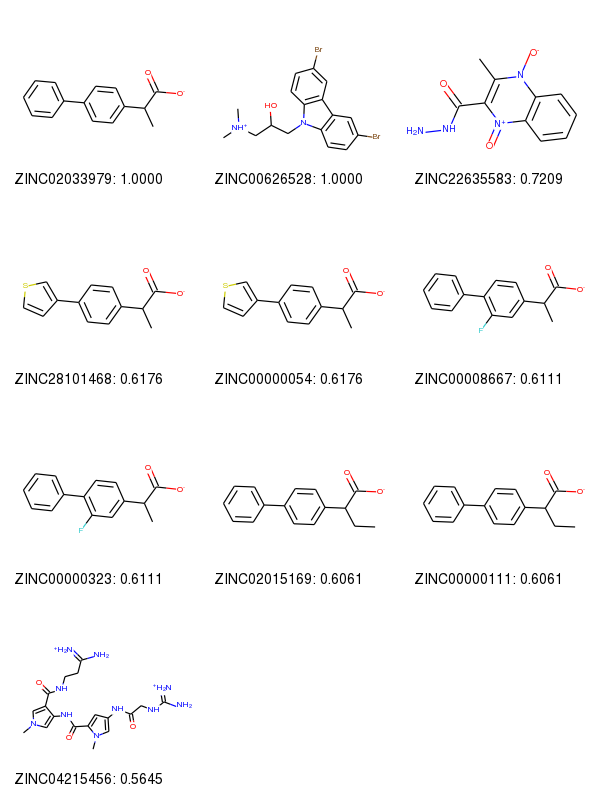

In [36]:
Draw.MolsToGridImage([zims[x[0]._idx] for x in tpicker[:10]],legends=['%s: %.4f'%(zims[x[0]._idx].GetProp('_Name'),x[1]) for x in tpicker])

In [32]:
spicker = SpreadPicker(numToPick=10,probeFps=probeFps,dataSet=dataset)

In [33]:
[(x[1],x[0]._idx) for x in spicker]

[(0.72093023255813948, 3517),
 (0.56451612903225812, 2104),
 (0.46551724137931033, 4094),
 (1.0, 8841),
 (1.0, 7),
 (0.53191489361702127, 5083),
 (0.23076923076923078, 9154),
 (0.4107142857142857, 5626),
 (0.61764705882352944, 9584),
 (0.29032258064516131, 3152)]

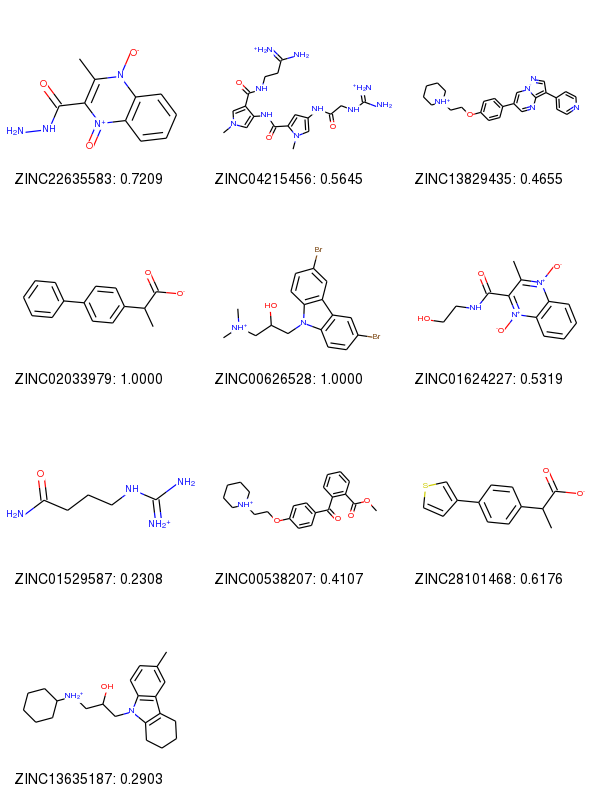

In [37]:
Draw.MolsToGridImage([zims[x[0]._idx] for x in spicker[:10]],legends=['%s: %.4f'%(zims[x[0]._idx].GetProp('_Name'),x[1])for x in spicker])